In [1]:
# from comet_ml import Experiment
from comet_ml import OfflineExperiment
import pandas as pd 
from cfg import *
import cv2
import numpy as np
from loader import data_pipe
from skimage.feature import texture
import glob
from personal_cls import run
import lightgbm as lgb
import random

from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.svm import SVC, NuSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt



def glcm_features(f):
    img = cv2.imread(f, 0)
    g = texture.greycomatrix(img, [1, 2, 3, 4, 5, 6, 7], [0, np.pi/2], levels=256, normed=True, symmetric=True)
    features = []
    for p in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']:
        f = texture.greycoprops(g, p)
        features.append(f)
    return np.array(features).flatten()


labels = [0, 1]
dtype = ['T1', 'T1c', 'T2', 'Flair']
# dtype = ['Flair']

rawX, y = [], []
for label in labels:
    pr_class = 'PR' if label else 'non_PR'
    for f in glob.glob(f'{segmented_img_dir}/{pr_class}/T1c/*.jpg'):
        mri_features = []
        # for d in ['T1c']:
        for d in dtype:
            textual_feature = glcm_features(f.replace('T1c', d))
            mri_features.append(textual_feature)
            
        rawX.append(np.array(mri_features).flatten())
        y.append(label)


X, y = np.array(rawX), np.array(y)
print(X.shape, y.shape)


(56, 336) (56,)


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Using '/home/rockyo/Chemei-PR/.cometml-runs' path as offline directory. Pass 'offline_directory' parameter into constructor or set the 'COMET_OFFLINE_DIRECTORY' environment variable to manually choose where to store offline experiment archives.


After VT transform | dim 112
accuracy |	 0.8575757575757577
precision |	 0.7666666666666666
recall |	 0.6333333333333333
roc_auc |	 0.7819444444444443


COMET INFO: Starting saving the offline archive
COMET INFO: To upload this offline experiment, run:
    comet upload /home/rockyo/Chemei-PR/.cometml-runs/b0cba1160a3e40ddad8c4a229e058a93.zip


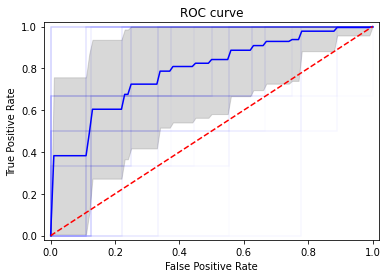

In [169]:
thr = .8
X = VarianceThreshold(threshold=(thr * (1 - thr))).fit_transform(X)

clf = NuSVC( max_iter=-1, nu=.09, kernel='rbf', degree=4, 
            probability=True,
            class_weight='balanced', 
            )
clf_name = clf.__class__.__name__

print('After VT transform | dim', X.shape[1])
clf = Pipeline([
    # ('scaler', preprocessing.Normalizer()),
    ('selector', SelectPercentile(chi2, percentile=65)), 
    ('svm', clf)
])
if __name__=='__main__':
    
    experiment = OfflineExperiment(
        api_key=COMET_APT_KEY,
        project_name=COMET_PROJECT_NAME,
        workspace=COMET_WORK_SPACE,
        display_summary_level=0,
        # disabled=True,
    )
    experiment.add_tags(['Img', clf_name])
    if len(dtype)>1 : experiment.add_tag('Mixed')
    else: experiment.add_tag(dtype[0])

    met =  ['accuracy', 'precision', 'recall', 'roc_auc']
    metric = ['test_' + val for val in met]
    base_fpr = np.linspace(0, 1, 101)
    tprs = []
    total_result = {}
    for m in metric: total_result[m] = []
    
    # SEEDS = random.sample(range(1, 100), NUM_RANDOM_STATE)
    for i in range(NUM_RANDOM_STATE):
        result = run(
            X, y, clf, thr=.60, seed=SEEDS[i],
            prob=True,
            ros=True
        )
        for m in metric: total_result[m].append(result[m])

        for j in range(len(result['test_fpr'])):
            plt.plot(result['test_fpr'][j], result['test_tpr'][j], 'b', alpha=0.015)
            tpr = np.interp(base_fpr, result['test_fpr'][j], result['test_tpr'][j])
            tpr[0] = 0.0
            tprs.append(tpr)
            
    for m in met: 
        print(m ,'|\t',
            #   np.mean(result[f'train_{m}']),
              np.mean(result[f'test_{m}']))
        experiment.log_metric(m, np.mean(result[f'test_{m}']))

    tprs = np.array(tprs)        
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)
     
tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve')        
experiment.log_parameters({'seeds':SEEDS})
experiment.log_figure('ROC curve', figure=plt)
experiment.end()
plt.show()